In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import dask.dataframe as dd

C:\Users\dagob\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [23]:
from dask.distributed import Client

In [24]:
client = Client()

In [25]:
client

Client Scheduler: tcp://127.0.0.1:3798 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.51 GB


Adding a really small blocksize to force dask to work with multiple partitions. Else it would be the same as just working with pandas

In [42]:
df_p = pd.read_csv("../data/hour.csv")
df_d = dd.read_csv("https://s3.eu-central-1.amazonaws.com/ie-mbd-advpython-ml-bikesharing-dask/hour.csv",
                   blocksize="250KB")

In [43]:
df_d.memory_usage().sum().compute()

2363944

In [44]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [45]:
df_d.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 17 entries, instant to cnt
dtypes: object(1), float64(4), int64(12)

In [46]:
df_p.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [47]:
df_d.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## 1.EDA

###  1.1. Identifying null values
##### According to the below the code this dataset does not have any null value.

In [48]:
df_p.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

We set up the "query" to calculate something but it's lazy evaluated until we call compute into it. IF we're working on an actualy cluster, then we can call client.persist(df_d) so that each node will do its calculation and then we can gather the results

In [63]:
nulls = df_d.isnull().sum()

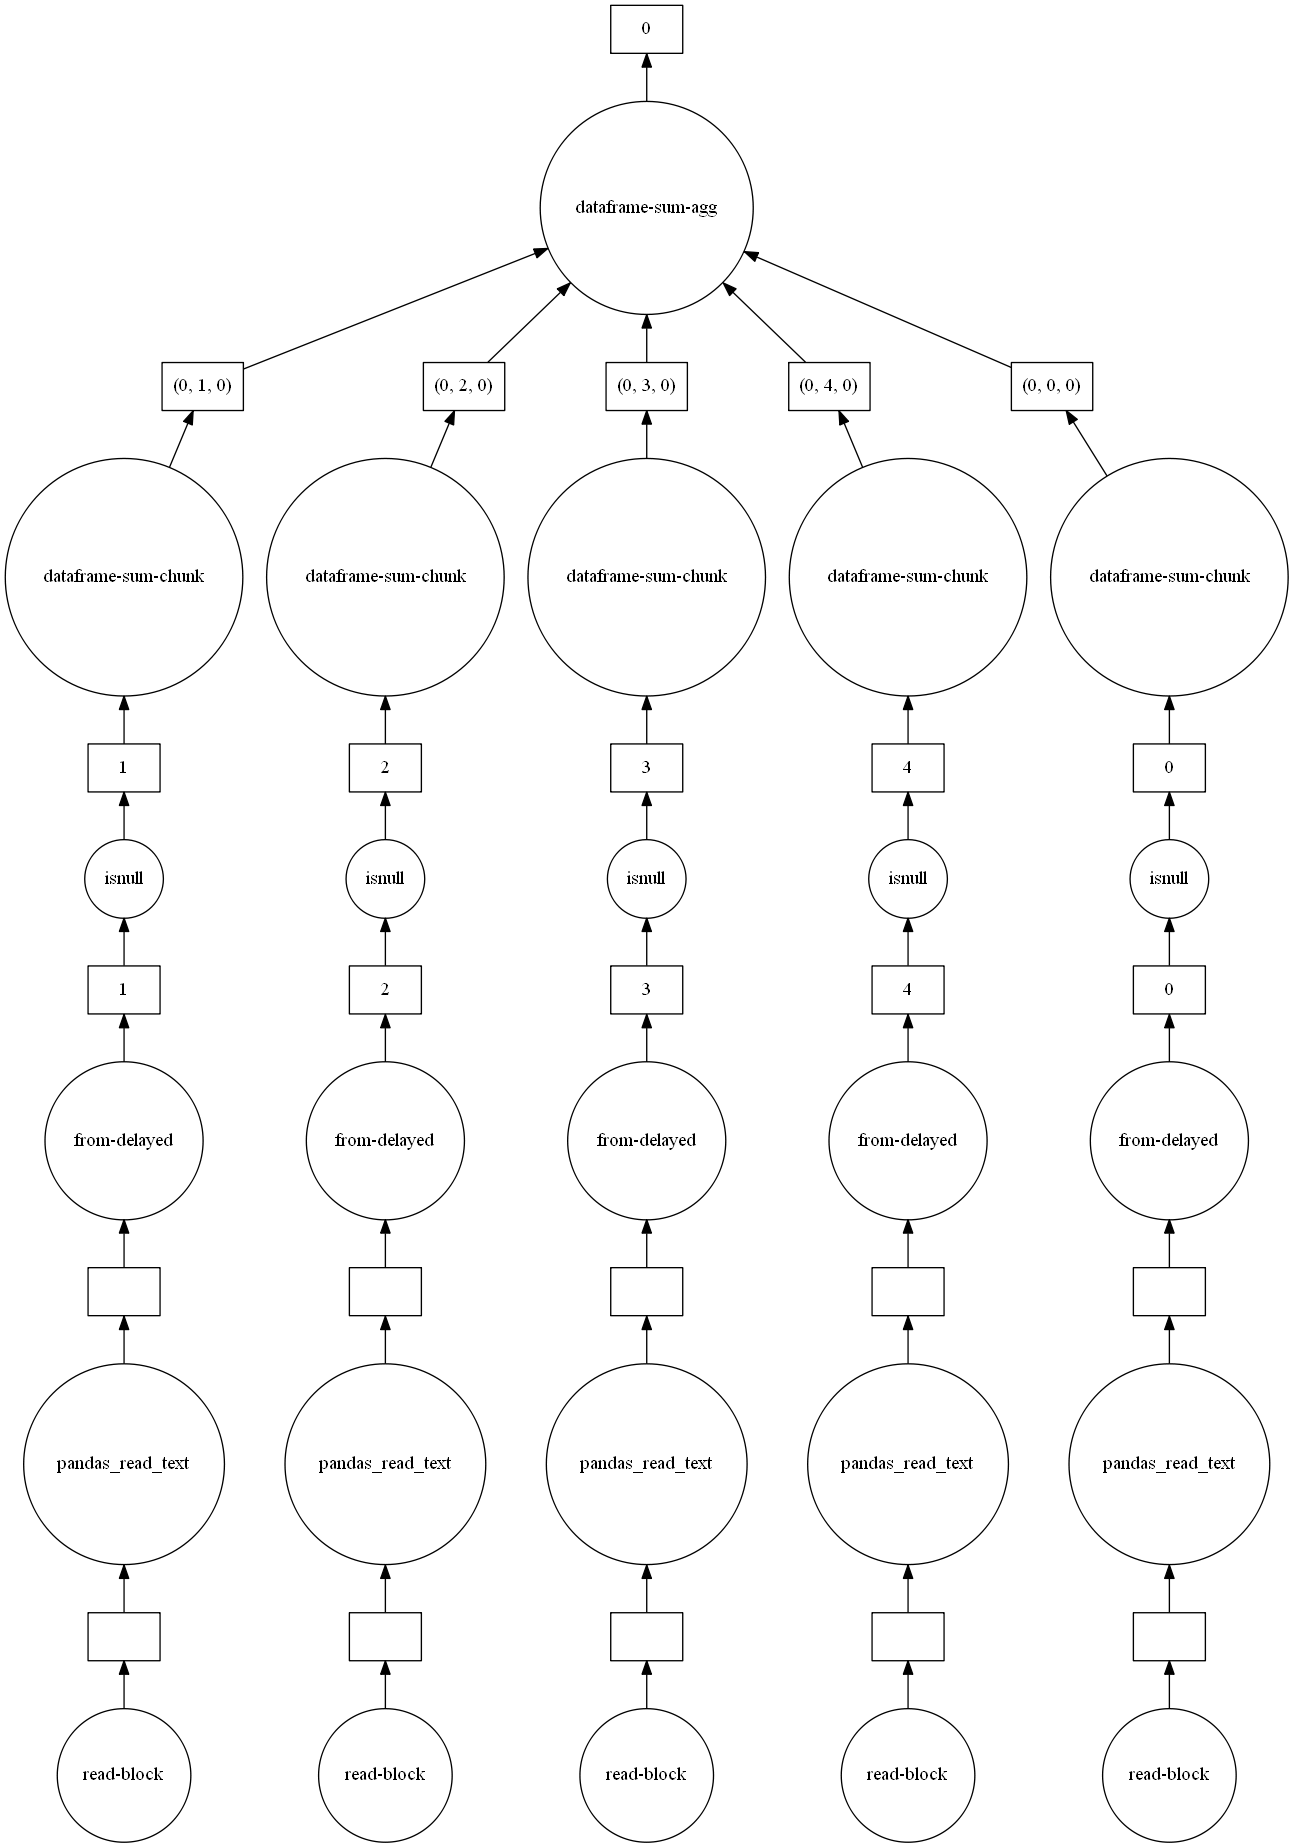

In [64]:
nulls.visualize()

In [65]:
nulls = client.persist(nulls)

then we can compute or gather-compute the results back to our machine

In [66]:
client.gather(nulls).compute()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

** Daks-persist-gather-compute Example**
This is an example to showcase how using persist can offload some computation in intermediate steps so that the final calculation is faster

In [72]:
mean_atemp = df_d.groupby('mnth')['atemp'].mean()

In [73]:
mean_atemp = client.persist(mean_atemp)

^ This is where the calculation will happen so we can have intermediate results to make subsequent queries faster

In [74]:
client.gather(mean_atemp).compute()  # This is almost instant

mnth
1     0.240676
2     0.300621
3     0.382299
4     0.457110
5     0.565662
6     0.638246
7     0.704094
8     0.651556
9     0.579344
10    0.473913
11    0.367339
12    0.326296
Name: atemp, dtype: float64

#### columns' name modification

In [75]:
df_p.rename(
    columns={
        "dteday": "datetime",
        "weathersit": "weather_condition",
        "cnt": "total_bike_rented",
    },
    inplace=True,
)

In [76]:
df_d = df_d.rename(columns={
    "dteday": "datetime",
        "weathersit": "weather_condition",
        "cnt": "total_bike_rented",
})

### Columns' type modification:
##### Taking a look at the dataset information, we see that some columns are not in the appropriate data type. For instance, datetime is an object while it should be in date format. also we have some columns that re factor but in the dataset are presented as integer, season, year, moth, hr, holiday, workingday, weather_condition are of those.

In [77]:
df_p["datetime"] = pd.to_datetime(df_p.datetime)

In [78]:
df_d["datetime"] = dd.to_datetime(df_d.datetime)

In [79]:
features_to_transform = ["season","yr","mnth","hr","holiday","weekday","workingday","weather_condition"]

In [83]:
def type_shifter(df, features, new_type):
    """this function takes the selected features of a data frame and 
    cast them to the new_type"""
    for i in features:
        df[i] = df[i].astype(new_type)
    print(df.info())
    return df

In [84]:
df_p = type_shifter(df_p, features_to_transform, "category")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant              17379 non-null int64
datetime             17379 non-null datetime64[ns]
season               17379 non-null category
yr                   17379 non-null category
mnth                 17379 non-null category
hr                   17379 non-null category
holiday              17379 non-null category
weekday              17379 non-null category
workingday           17379 non-null category
weather_condition    17379 non-null category
temp                 17379 non-null float64
atemp                17379 non-null float64
hum                  17379 non-null float64
windspeed            17379 non-null float64
casual               17379 non-null int64
registered           17379 non-null int64
total_bike_rented    17379 non-null int64
dtypes: category(8), datetime64[ns](1), float64(4), int64(4)
memory usage: 1.3 MB
None


In [85]:
df_d = type_shifter(df_d, features_to_transform, "category")

<class 'dask.dataframe.core.DataFrame'>
Columns: 17 entries, instant to total_bike_rented
dtypes: category(8), datetime64[ns](1), float64(4), int64(4)None


### Renaming the categorical variables' levels:

#### In the priginal dataset all the weekdays and months are presented as integer, although we have already casted them to categorical type, in order to make them more informative, we would change the levels' names:

In [86]:
df_p['weekday']=df_p['weekday'].map({
        0: "Sunday",
        1: "Monday",
        2: "Tuesday",
        3: "Wednesday",
        4: "Thursday",
        5: "Friday",
        6: "Saturday",
    })

In [87]:
df_d['weekday']=df_d['weekday'].map({
        0: "Sunday",
        1: "Monday",
        2: "Tuesday",
        3: "Wednesday",
        4: "Thursday",
        5: "Friday",
        6: "Saturday",
    })

**Here we will check which season is which numbner based on the unique months based on that season**

As we don't want to recompute everythin every time, especially if we're dealing with huge ammounts of data, we will convert a small sample on the dataset to a pandas dataframe (that would fit in memory) and then check things as we don't need all the data to determine the seasons by looking at the unique months

### Finding Seasons from the unique months

In [100]:
df_p.groupby('season')['mnth'].apply(np.unique)

season
1      [1, 2, 3, 12]
2       [3, 4, 5, 6]
3       [6, 7, 8, 9]
4    [9, 10, 11, 12]
Name: mnth, dtype: object

We can see that season 1 is winter and then Spring, Summer, Autumn come

In [89]:
sample_df = df_d.sample(frac=0.2)

In [113]:
sample_df[sample_df['season'] == 1]['mnth'].unique().compute()

0     1
1     2
2     3
3    12
Name: mnth, dtype: category
Categories (4, int64): [1, 2, 3, 12]

In [114]:
sample_df[sample_df['season'] == 2]['mnth'].unique().compute()

0    4
1    6
2    3
3    5
Name: mnth, dtype: category
Categories (4, int64): [4, 6, 3, 5]

In [115]:
sample_df[sample_df['season'] == 3]['mnth'].unique().compute()

0    7
1    6
2    8
3    9
Name: mnth, dtype: category
Categories (4, int64): [7, 6, 8, 9]

In [116]:
sample_df[sample_df['season'] == 4]['mnth'].unique().compute()

0    10
1     9
2    11
3    12
Name: mnth, dtype: category
Categories (4, int64): [10, 9, 11, 12]

In [117]:
df_p['season']=df_p['season'].map({1: "Winter", 2: "Spring", 3: "Summer", 4: "Autumn"})

In [118]:
df_d['season'] = df_d['season'].map({1: "Winter", 2: "Spring", 3: "Summer", 4: "Autumn"})

In [119]:
df_p['mnth']=df_p['mnth'].map({
        1: "01-Jan",
        2: "02-Feb",
        3: "03-Mar",
        4: "04-Apr",
        5: "05-May",
        6: "06-Jun",
        7: "07-Jul",
        8: "08-Aug",
        9: "09-Sep",
        10: "10-Oct",
        11: "11-Nov",
        12: "12-Dec",
    })

In [120]:
df_d['mnth']=df_d['mnth'].map({
        1: "01-Jan",
        2: "02-Feb",
        3: "03-Mar",
        4: "04-Apr",
        5: "05-May",
        6: "06-Jun",
        7: "07-Jul",
        8: "08-Aug",
        9: "09-Sep",
        10: "10-Oct",
        11: "11-Nov",
        12: "12-Dec",
    })

In [121]:
df_p['yr']=df_p['yr'].map({0:'2011',1:'2012'})

In [122]:
df_d['yr']=df_d['yr'].map({0:'2011',1:'2012'})

In [123]:
df_p['weather_condition']=df_p['weather_condition'].map({1: "A", 2: "B", 3: "C", 4: "D"})

In [124]:
df_d['weather_condition']=df_d['weather_condition'].map({1: "A", 2: "B", 3: "C", 4: "D"})

In [125]:
df_p.head()

,instant,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weather_condition,temp,atemp,hum,windspeed,casual,registered,total_bike_rented
0,1,2011-01-01,Winter,2011,01-Jan,0,0,Saturday,0,A,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,Winter,2011,01-Jan,1,0,Saturday,0,A,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,Winter,2011,01-Jan,2,0,Saturday,0,A,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,Winter,2011,01-Jan,3,0,Saturday,0,A,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,Winter,2011,01-Jan,4,0,Saturday,0,A,0.24,0.2879,0.75,0.0,0,1,1


In [126]:
df_d.head()

,instant,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weather_condition,temp,atemp,hum,windspeed,casual,registered,total_bike_rented
0,1,2011-01-01,Winter,2011,01-Jan,0,0,Saturday,0,A,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,Winter,2011,01-Jan,1,0,Saturday,0,A,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,Winter,2011,01-Jan,2,0,Saturday,0,A,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,Winter,2011,01-Jan,3,0,Saturday,0,A,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,Winter,2011,01-Jan,4,0,Saturday,0,A,0.24,0.2879,0.75,0.0,0,1,1


In [133]:
df_d.count().compute()

instant              17379
datetime             17379
season               17379
yr                   17379
mnth                 17379
hr                   17379
holiday              17379
weekday              17379
workingday           17379
weather_condition    17379
temp                 17379
atemp                17379
hum                  17379
windspeed            17379
casual               17379
registered           17379
total_bike_rented    17379
dtype: int64

### Visualization
#### In order to see if there is any specific trend in different time intervals we present the target variable over month, day and hour to get a more clear vision of the target variable evolution.

### Note: For distributed datasets we would normally sample the data to visualize as it would require all the data to come into a single machine, which if we were using enough data to warrant distribution then it would probably crash the machine. So for the sake of this example, we will sample the dataset every time we need to compute to simulate how this would work with a bigger dataset

In [134]:
# Count of records
df_p.count()['instant']

17379

In [135]:
# Count of records computing everything
df_d['instant'].count().compute()

17379

In [142]:
# Count by Partition (This is stupid as it can't be parallelized)
for i in range(df_d.npartitions):
    count = df_d['instant'].get_partition(i).count().compute()
    print("Partition {}: {} records".format(i, count))

Partition 0: 3838 records
Partition 1: 3768 records
Partition 2: 3767 records
Partition 3: 3701 records
Partition 4: 2305 records


So we will sample and compute before visualizing with 30% of the dataframe as an example. Normally

In [143]:
sns.set_style('whitegrid')
sns.set_context('talk')
params = {'legend.fontsize': 'large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}

plt.rcParams.update(params)

[Text(0.5, 1.0, 'Hourly distribution of counts in different seasons')]

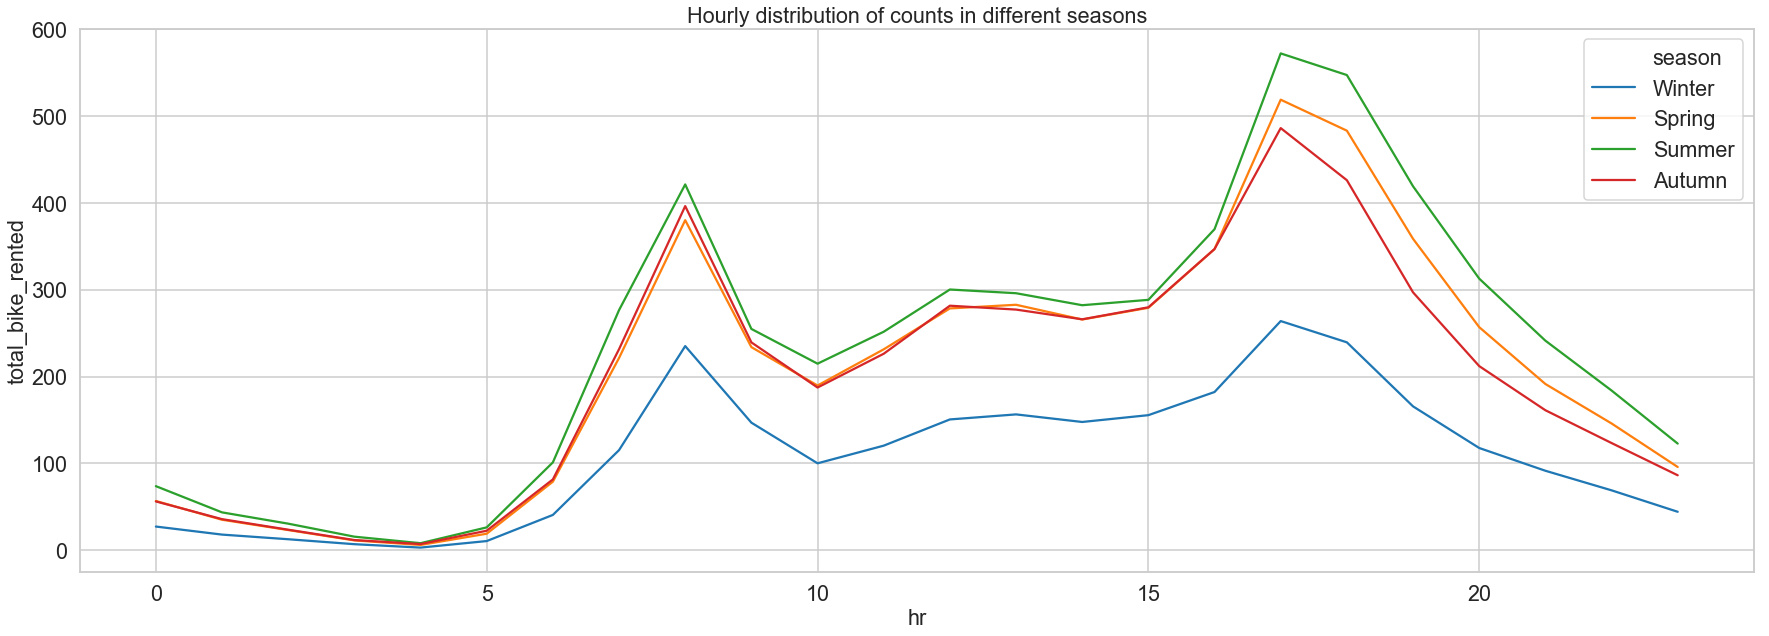

In [144]:
fig, ax = plt.subplots()
sns.lineplot(
    data=df_p[["hr", "total_bike_rented", "season"]],
    x="hr",
    y="total_bike_rented",
    hue="season",
    ax=ax,
    err_style=None
)
ax.set(title="Hourly distribution of counts in different seasons")

[Text(0.5, 1.0, 'Hourly distribution of counts in different seasons')]

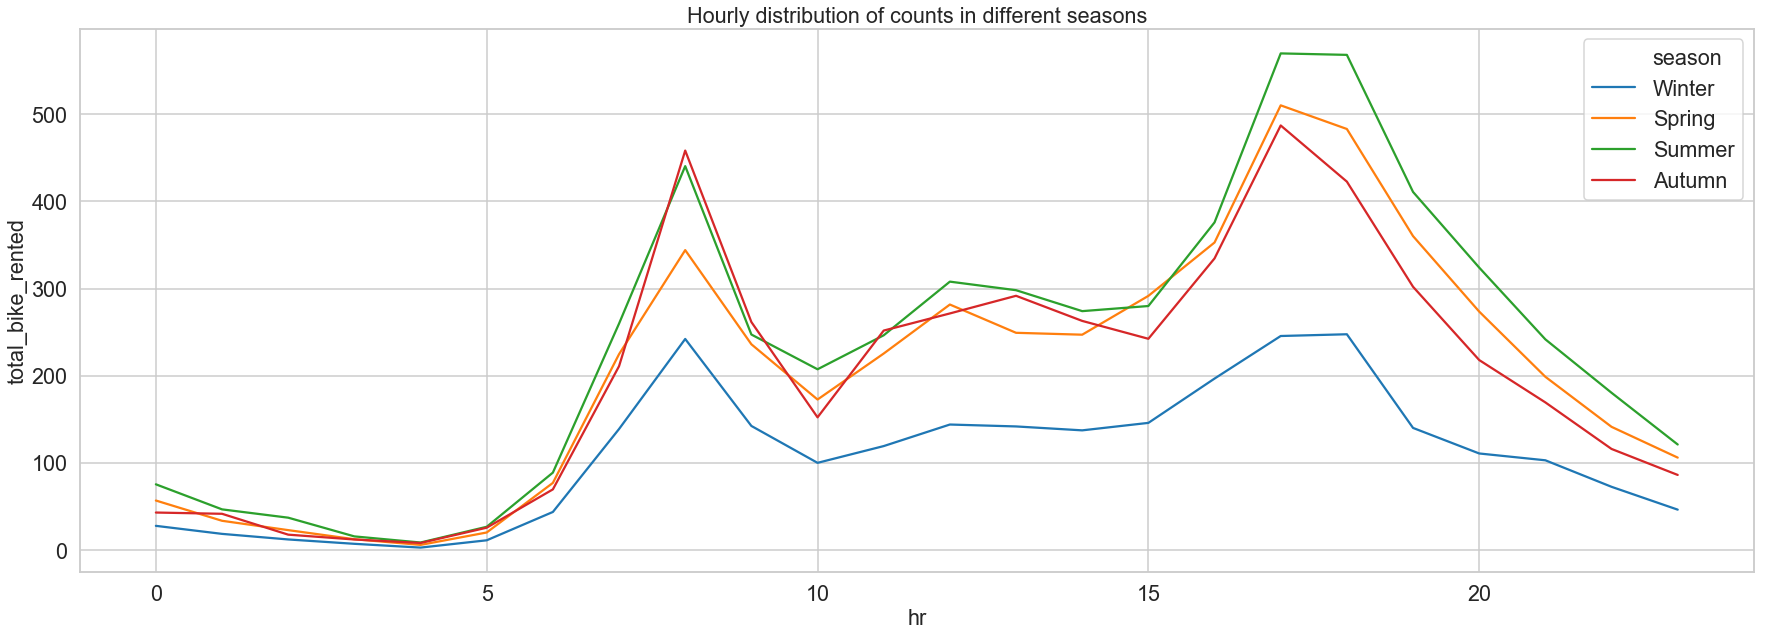

In [145]:
fig, ax = plt.subplots()
sns.lineplot(
    data=df_d[["hr", "total_bike_rented", "season"]].sample(frac=0.3).compute(),
    x="hr",
    y="total_bike_rented",
    hue="season",
    ax=ax,
    err_style=None
)
ax.set(title="Hourly distribution of counts in different seasons")


#### The above graph shows that bike rental business is fairly seasonal and aslo correlated with the day time.

[Text(0.5, 1.0, ' Hourly distribution of counts over the weekdays')]

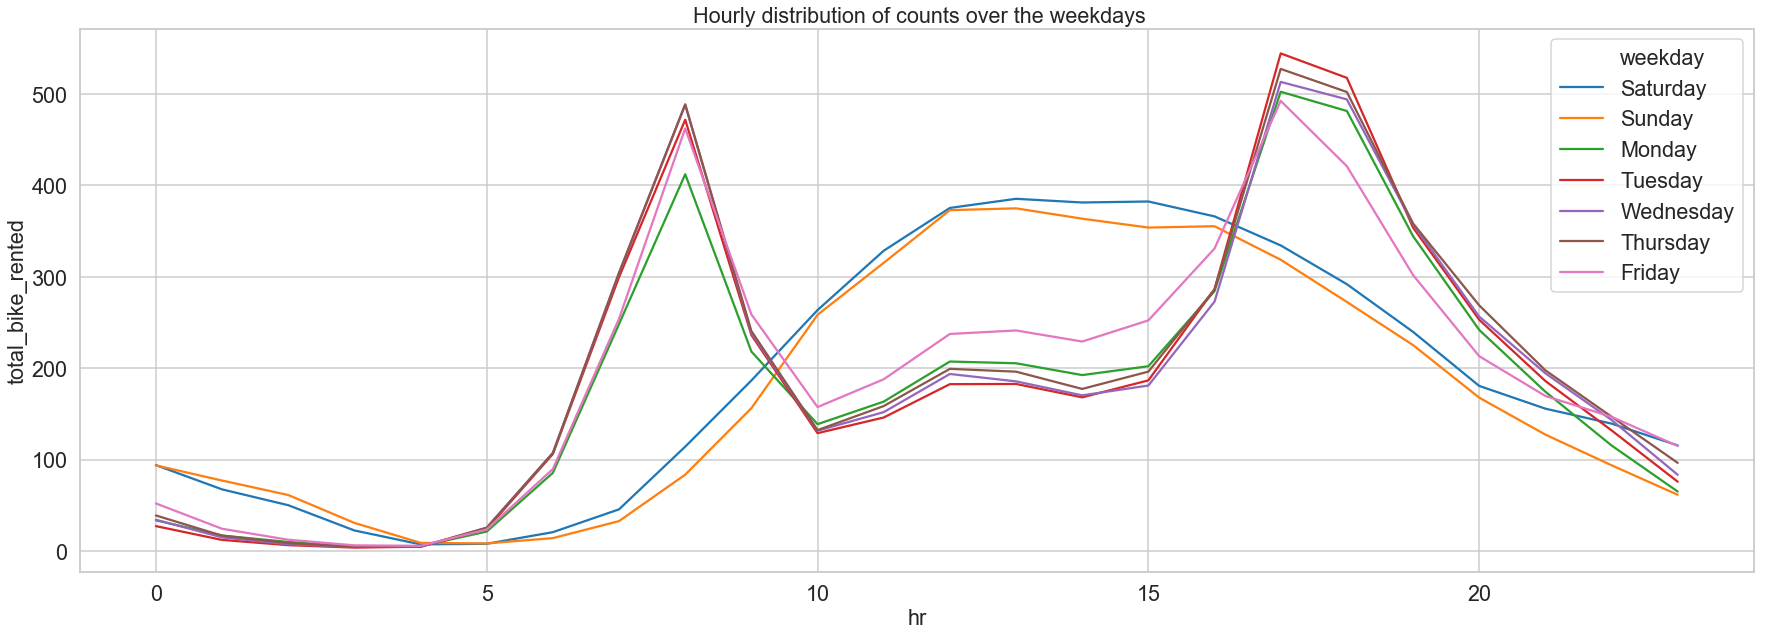

In [146]:
fig, ax = plt.subplots()
sns.lineplot(
    data=df_p[["hr", "total_bike_rented", "weekday"]],
    x="hr",
    y="total_bike_rented",
    hue="weekday",
    ax=ax,
    err_style=None
    
    
)
ax.set(title=" Hourly distribution of counts over the weekdays")

[Text(0.5, 1.0, ' Hourly distribution of counts over the weekdays')]

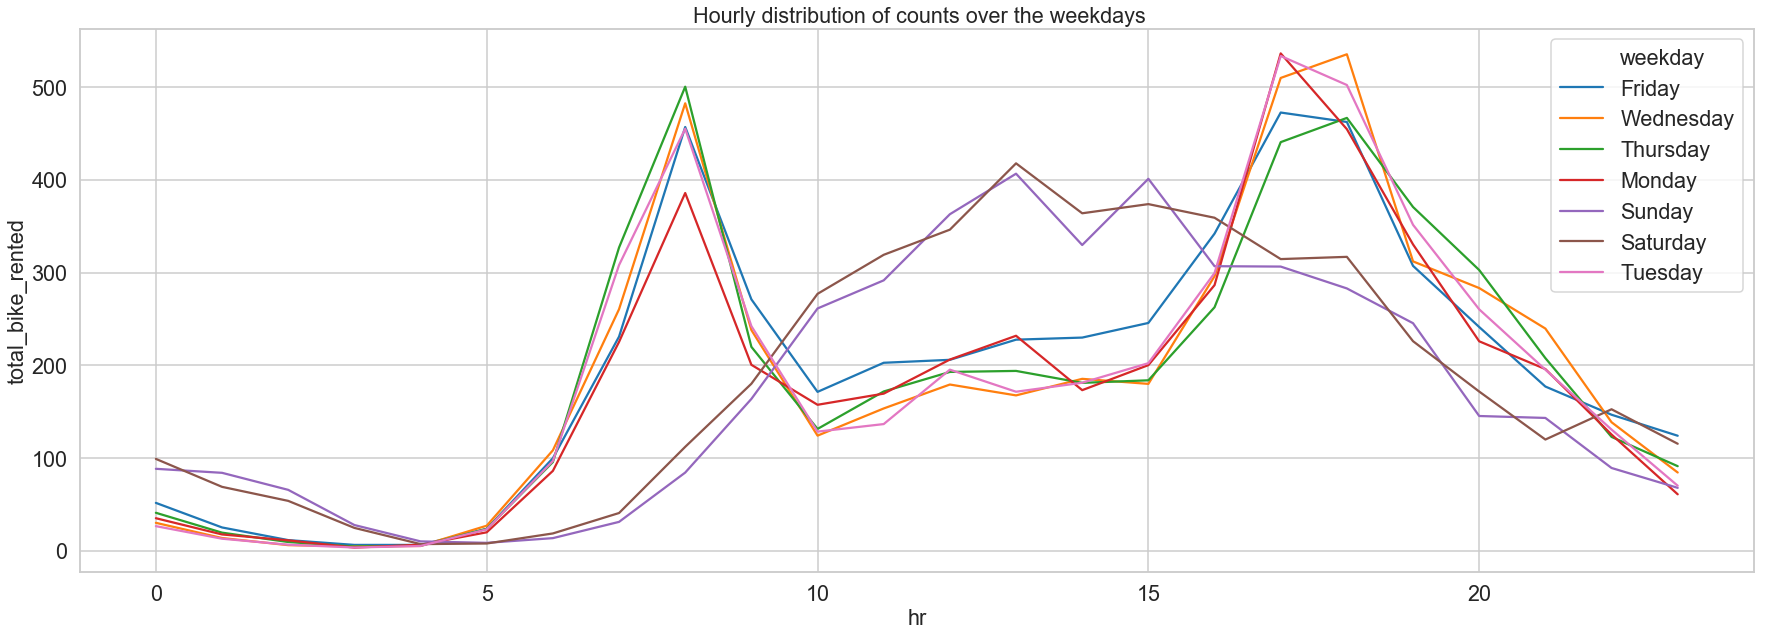

In [147]:
fig, ax = plt.subplots()
sns.lineplot(
    data=df_d[["hr", "total_bike_rented", "weekday"]].sample(frac=0.3).compute(),
    x="hr",
    y="total_bike_rented",
    hue="weekday",
    ax=ax,
    err_style=None
    
    
)
ax.set(title=" Hourly distribution of counts over the weekdays")

**The Above graph shows us that the behaviour is fundamentally different between weekdays and weekends where on one the pattern seems to revolve around "commuting" and over the weekds noon-earlyafternoon leisure"**

[Text(0.5, 1.0, 'Monthly distribution of counts')]

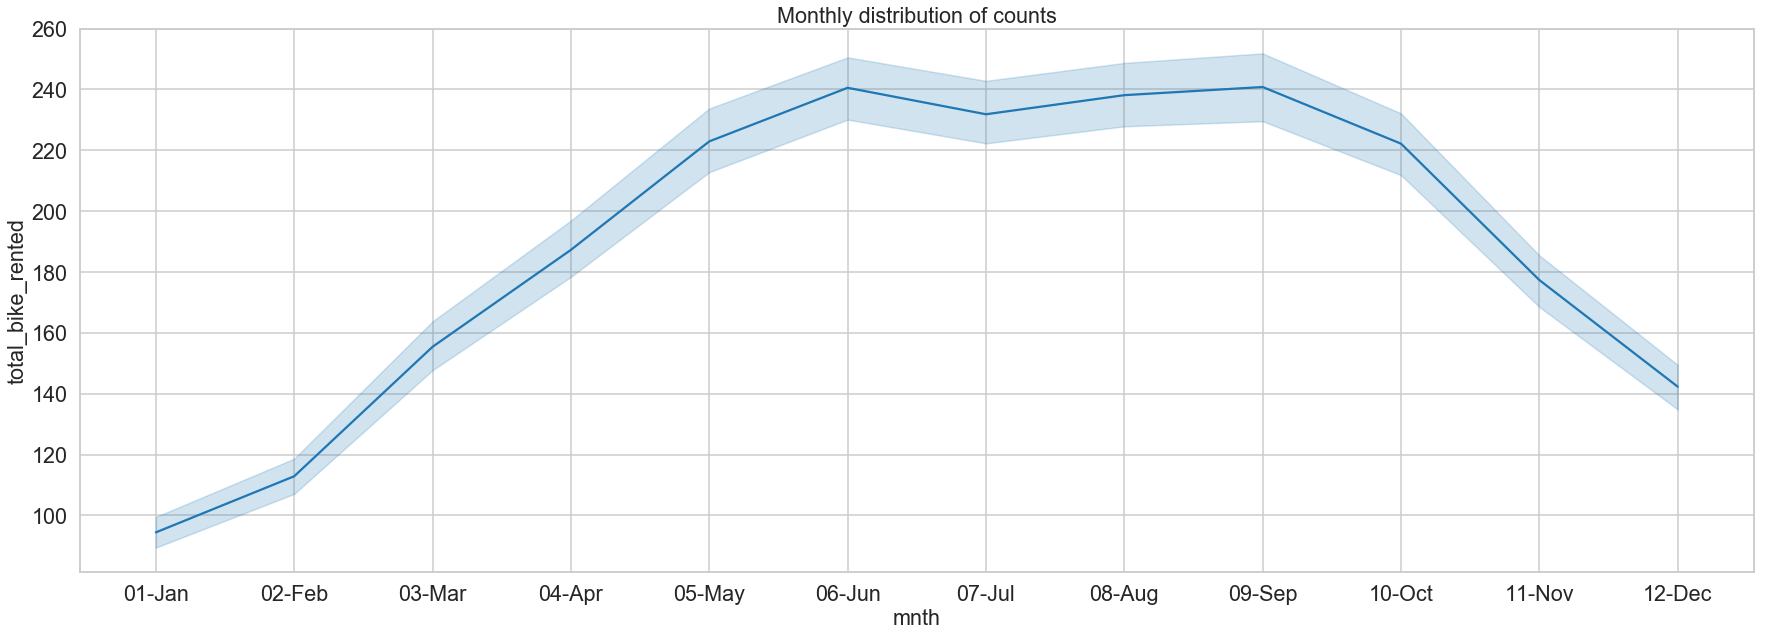

In [148]:
fig, ax = plt.subplots()
sns.lineplot(
    data=df_p[["mnth", "total_bike_rented", "yr"]], x="mnth", y="total_bike_rented", ax=ax,
)
ax.set(title="Monthly distribution of counts")

[Text(0.5, 1.0, 'Monthly distribution of counts')]

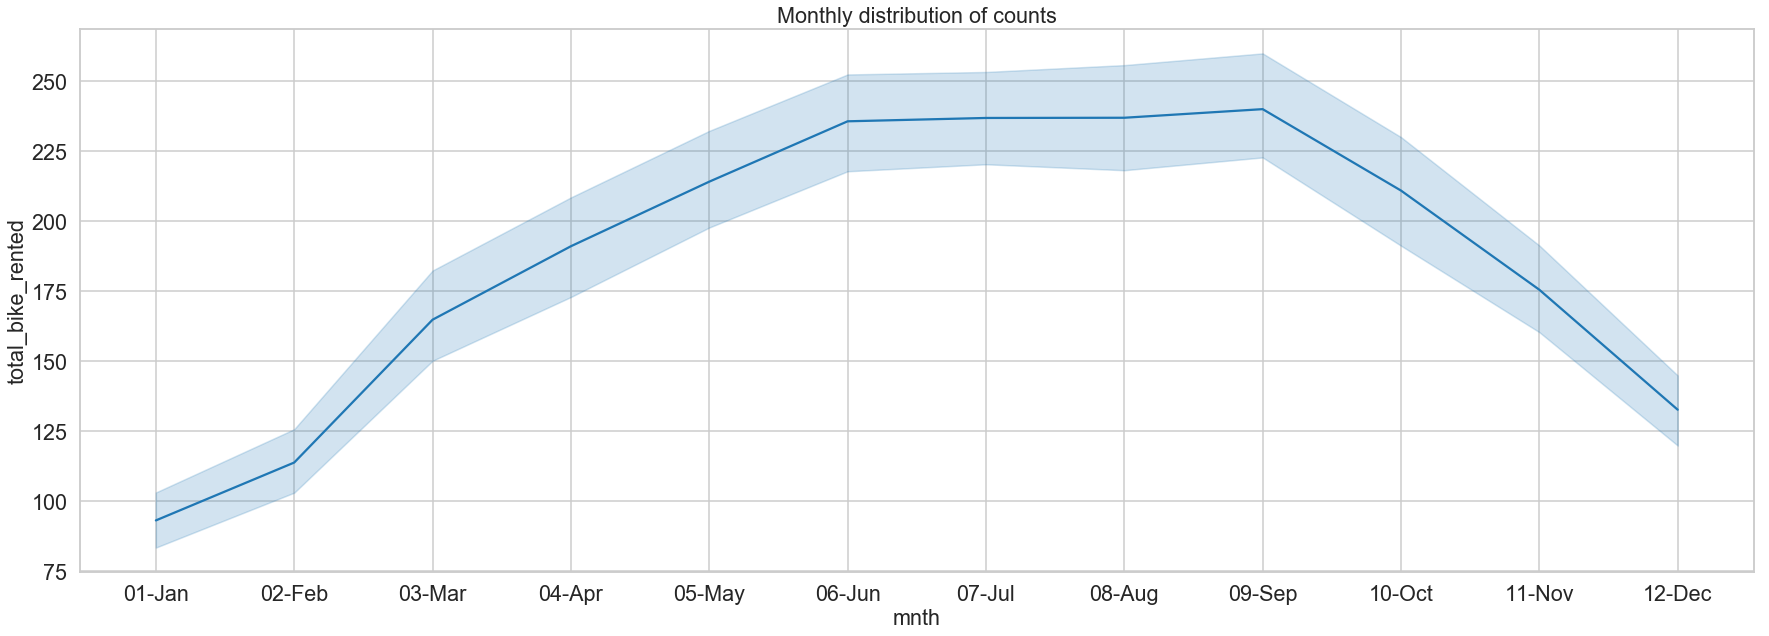

In [149]:
fig, ax = plt.subplots()
sns.lineplot(
    data=df_d[["mnth", "total_bike_rented", "yr"]].sample(frac=0.3).compute(), x="mnth", y="total_bike_rented", ax=ax,
)
ax.set(title="Monthly distribution of counts")

**We can see that the usage increases during the summer months and declines in the winter months which is logical **

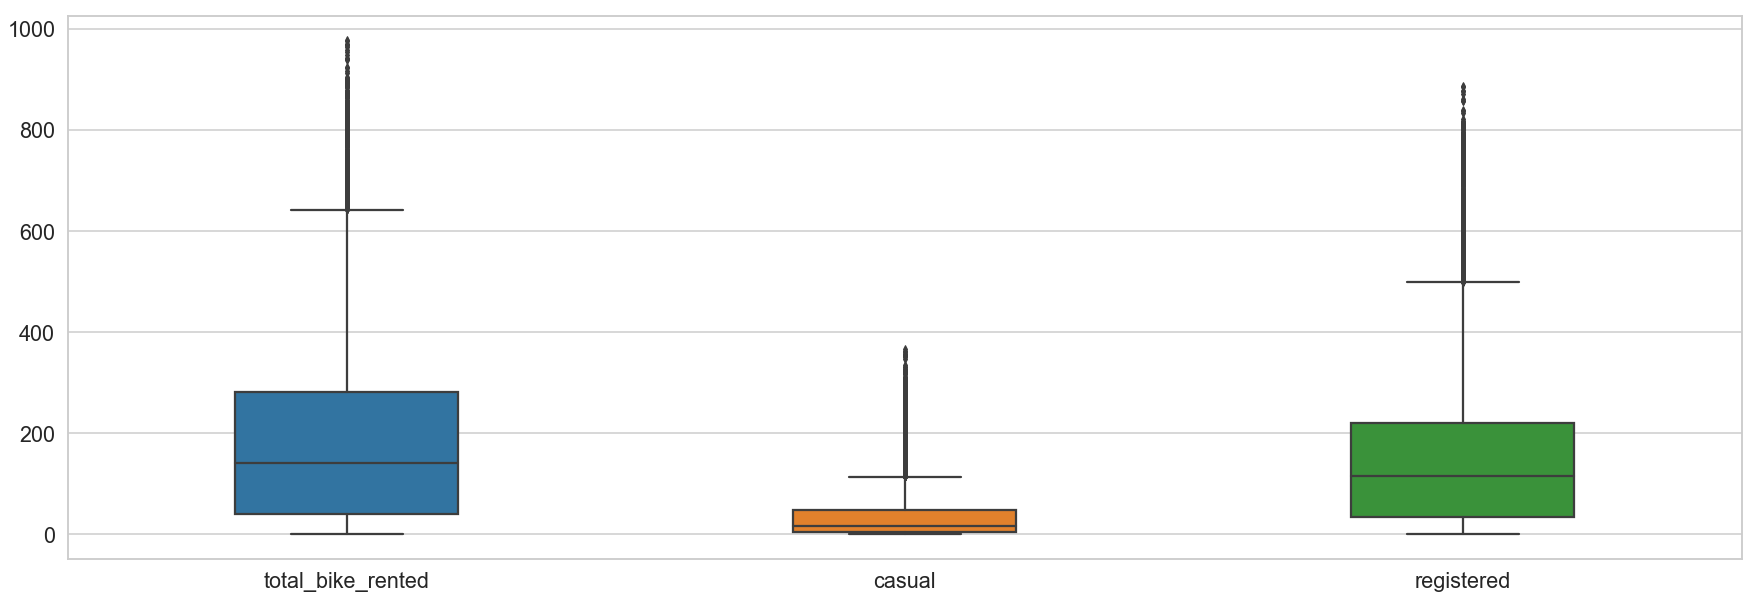

In [150]:
fig,ax = plt.subplots()
sns.boxplot(data=df_p[['total_bike_rented',
                          'casual',
                          'registered']],ax=ax,width=0.4)

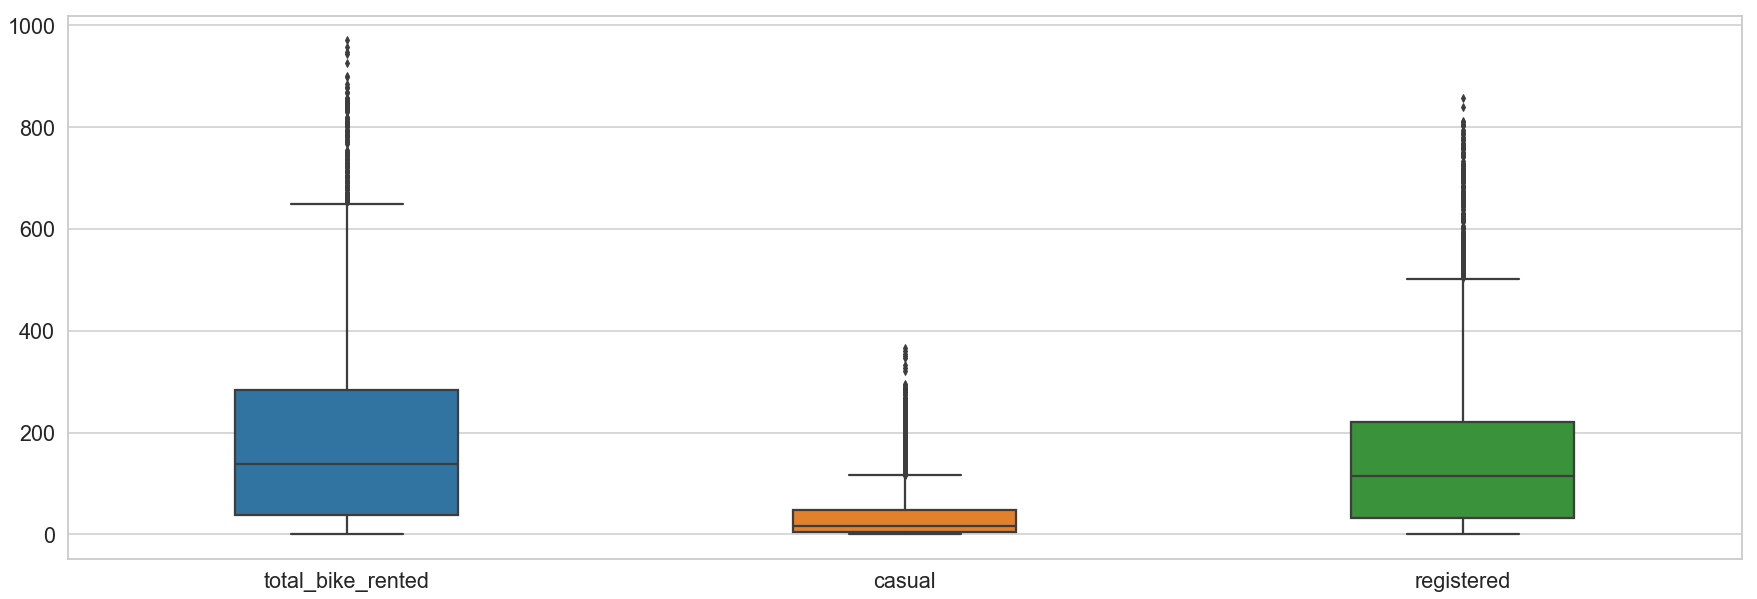

In [151]:
fig,ax = plt.subplots()
sns.boxplot(data=df_d[['total_bike_rented',
                          'casual',
                          'registered']].sample(frac=0.3).compute()
            ,ax=ax,width=0.4)

### Features correlation

#### In order to avoid futrther error in the modeling part it is better to remove potential multicollinearity between features; therefore, we should measure the correlation coefficient between different featuers.

In [ ]:
correlation=df[['temp','atemp','hum','windspeed','casual','registered','total_bike_rented']].corr()
#correlation.style.background_gradient(cmap='GnBu').set_precision(2)
sns.heatmap(correlation,cmap='coolwarm',square=True,center=0,annot=True)

##### As could be seen above atemp and temp are highly correlated so we will only keep temp and drop the atem from the dataset and other side we cannot say that anu other feature is absolutely useless for Predicting the target Variable so we will keep the other numeric features.

In [ ]:
df.drop("atemp",1,inplace=True)

###### As the goal of this exercise is to predict the total_bike_rented we will remove casual and registered from the dataset

In [ ]:
df.drop(["casual","registered"],1,inplace=True)

In [ ]:
df.head()

In [ ]:
df.shape

### Exploring numeric features:

Linear regression algorithm is highly sensitive to the numerical features distribution and also outliers. It means if numeric features are highly skewd probably the regression model would be affected in a negative way. Outliers also are quiet important, and having some outliers in a linear model could change the result totally; therefore in this part we focus on cleaning the numeric values. 

In [ ]:
numeric_cols= list(df.select_dtypes(include=np.number).columns.values)
numeric_cols

In [ ]:
counter=1
for i in df[numeric_cols].columns.values:
    plt.subplot(1, len(numeric_cols),counter)
    plt.hist(df[i])
    plt.title(str(i)+" "+ "distribution")
    counter+=1



#### Considering the sensiticity of the Linear regression model to numeric features' skewness we try modifiy this by transforming variables with skewness higher than our threshold.

In [ ]:
from scipy.stats import skew

In [ ]:
df[['windspeed','hum','temp','total_bike_rented']].apply(lambda x: abs(skew(x))>0.75)

###### As could be seen above our target variable is highly skewed and needs to get transformed. Doing so, we take sqaure root of the target variable and the skewness would be in the acceptabel range now:

In [ ]:
skew(np.log(df.total_bike_rented))

#### As log transformation in this case cannot remove the skewness we try with sqrt

In [ ]:
skew(np.sqrt(df.total_bike_rented))

In [ ]:
df['total_bike_rented']=np.sqrt(df.total_bike_rented)
df.head()

#### Outliers:

In [ ]:
fig,ax = plt.subplots()
sns.boxplot(data=df[['hum',
                          'temp',
                          'windspeed']],ax=ax,width=0.4)

#### Exploring the boxplots for univariate analysis of outliers it seems that the numeric features containing outliers are hum and windspeed, however it is not enough yet to consider those points outliers. Therefore we do a multivariate analysis of windspeed and target variable to see if we can get more information. 

In [ ]:
sns.scatterplot(df['hum'],df['total_bike_rented'])

In [ ]:
df.loc[df['hum']==0,'hum']=0.1

In [ ]:
sns.scatterplot(df['windspeed'],df['total_bike_rented'])

##### The above scatter plot shows that probably winspeed values over 0.7 could be consider outliers, therefore our strategy at this point is to clip the windspeed values over 0.7 to o.7.

In [ ]:
df.loc[df['windspeed']>0.7,'windspeed']=0.7

In [ ]:
sns.scatterplot(df['windspeed'],df['total_bike_rented'])

#### Converting categoriacal features to dummy variables.

In [ ]:
df=pd.get_dummies(df)

In [ ]:
df.head()

#### As we are going to use the last quarter of 2012 as the test set we will keep the index from which this quarter starts and it is 15212.

#### Having finished the feature engineering part, we move to creating model

In [ ]:
y = df['total_bike_rented']
X = df.drop(['datetime','total_bike_rented'],axis=1)

In [ ]:
X_train= X[:15211]
X_test = X[15211:]
y_train= y[:15211]
y_test = y[15211:]

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

### Trying with Linear regression

In [ ]:
lr=LinearRegression()
lr.fit(X_train,y_train)
cross_validation = cross_val_score(lr,X_train,y_train,cv=5)

In [ ]:
cross_validation

In [ ]:
lr_ridge=Ridge()
lr_ridge.fit(X_train,y_train)
Ridge_cv=cross_val_score(lr_ridge,X_train,y_train,cv=5)

In [ ]:
Ridge_cv

In [ ]:
lr_lasso=Lasso(alpha=0.001)
lr_lasso.fit(X_train,y_train)
Lasso_cv=cross_val_score(lr_lasso,X_train,y_train,cv=5)

In [ ]:
Lasso_cv

In [ ]:
lr_lasso.score(X_test,y_test)

## Optimizing

In [ ]:
alphas = np.linspace(0.001,0.003,9)
score = []
for alpha in alphas:
    model = Lasso(alpha=alpha, normalize=False)
    model.fit(X_train, y_train)
    score.append(model.score(X_test, y_test))
plt.plot(alphas, score)

In [ ]:
best_lasso = Lasso(alpha=0.00150)

In [ ]:
best_lasso.fit(X_train, y_train)

#### Predicting the test values

In [ ]:
y_pred=best_lasso.predict(X_test)

In [ ]:
plt.scatter(y_test,y_pred)

In [ ]:
result = pd.DataFrame({'truth':y_test, 'pred':y_pred})
result['abs_diff'] = np.abs(y_test-y_pred)

In [ ]:
sns.scatterplot(data=result, x="pred", y='truth', hue='abs_diff', palette='inferno')

#### For getting the true prediction we should undo the sqrt transformation :

In [ ]:
RMSE = np.sqrt(np.mean((y_test ** 2 - y_pred ** 2) ** 2))
MSE = RMSE ** 2
print("MSE::{}".format(MSE))
print("RMSE::{}".format(RMSE))

In [ ]:
np.sqrt(np.mean((np.log(y_pred**2+1)-np.log(y_test**2+1))**2))

#### As the R^2 score is not good enough in both Lasso and Ridge regression we will try other algorithm. RandomForest seems to be a good match for this dataset, as it does not have many features.

### Modeling using random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [ ]:
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={"max_depth": (5, 10, 15, 20), "n_estimators": (50,100,150, 200)},
        cv=3,
        scoring="neg_mean_squared_error",
        verbose=1,
        n_jobs=3,
    )

grid_result = gsc.fit(X_train, y_train)

In [ ]:
print("Best Score: {}. with Params: {}".format(grid_result.best_score_, grid_result.best_params_))

#### Having done the grid search we will do the model for the best parameters obtained from the grid search.

In [ ]:
rf = grid_result.best_estimator_
rf.fit(X_train, y_train)
rf.predict(X_test)

In [ ]:
rf.score(X_train, y_train)

In [ ]:
rf.score(X_test, y_test)

In [ ]:
y_pred_rf = rf.predict(X_test)

In [ ]:
RMSE = np.sqrt(np.mean((y_test ** 2 - y_pred_rf ** 2) ** 2))
MSE = RMSE ** 2
print("MSE::{}".format(MSE))
print("RMSE::{}".format(RMSE))

### We got much better result from random forest regressor R^2=0.86 while with linear regression the best R^2 was =0.74
### MSE also for random forest is about half of that for linear regression model.

# SHOTGUN STRATEGY!!!!!

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
from sklearn.linear_model import LinearRegression, ARDRegression, BayesianRidge, ElasticNet, Lasso, Ridge
from sklearn.linear_model import HuberRegressor, PassiveAggressiveRegressor, SGDRegressor, TheilSenRegressor

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

In [ ]:
from sklearn.metrics import median_absolute_error
import time

In [ ]:
total_models = pd.DataFrame()

In [ ]:
model_names = ['LinearRegression', 'BayesianRidge', 'ElasticNet', 'Lasso', 'Ridge',
              'HuberRegressor', 'PassiveAggressiveRegressor', 'SGDRegressor', 'TheilSenRegressor']
models = [LinearRegression(), BayesianRidge(), ElasticNet(), Lasso(), Ridge(),
         HuberRegressor(), PassiveAggressiveRegressor(), SGDRegressor(), TheilSenRegressor()]

mse = []
mae = []
msle = []
medae = []
r2 = []
trained_model= []
time_train = []

for model in models:
    start = time.time()
    model.fit(X_train, y_train)
    
    mse.append(mean_squared_error(y_test, model.predict(X_test)))
    mae.append(mean_absolute_error(y_test, model.predict(X_test)))
    msle.append(mean_squared_log_error(y_test, abs(model.predict(X_test))))
    medae.append(median_absolute_error(y_test, model.predict(X_test)))
    r2.append(model.score(X_test, y_test))
    
    stop = time.time()
    tr_time = stop - start
    time_train.append(tr_time)
    trained_model.append(model)
    print("Model Trained")
models = pd.DataFrame(data = {'model': model_names, 'time_train': time_train,
                      'MAE': mae, 'MSE': mse, 'MSLE': msle, 'MEDAE': medae, 'R2': r2})

In [ ]:
total_models = pd.concat([total_models, models])

In [ ]:
models.sort_values('MSE')

In [ ]:
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor,ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor 

In [ ]:
model_names = ['AdaBoostRegressor','BaggingRegressor', 'ExtraTreesRegressor',
               'GradientBoostingRegressor', 'RandomForestRegressor']
models = [AdaBoostRegressor(),BaggingRegressor(), ExtraTreesRegressor(),
               GradientBoostingRegressor(), RandomForestRegressor()]

mse = []
mae = []
msle = []
medae = []
r2 = []
trained_model= []
time_train = []

for model in models:
    start = time.time()
    model.fit(X_train, y_train)
    
    mse.append(mean_squared_error(y_test, model.predict(X_test)))
    mae.append(mean_absolute_error(y_test, model.predict(X_test)))
    msle.append(mean_squared_log_error(y_test, abs(model.predict(X_test))))
    medae.append(median_absolute_error(y_test, model.predict(X_test)))
    r2.append(model.score(X_test, y_test))
    
    stop = time.time()
    tr_time = stop - start
    time_train.append(tr_time)
    trained_model.append(model)
    print("Model Trained")
models = pd.DataFrame(data = {'model': model_names, 'time_train': time_train,
                      'MAE': mae, 'MSE': mse, 'MSLE': msle, 'MEDAE': medae, 'R2': r2})

In [ ]:
total_models = pd.concat([total_models, models])

In [ ]:
models.sort_values('MSE')

In [ ]:
from sklearn.svm import LinearSVR, NuSVR, SVR

In [ ]:
model_names = ['LinearSVR', 'NuSVR-Linear','NuSVR-Poly','NuSVR-RBF','NuSVR-Sigmoid',
               'SVR-Linear','SVR-Poly','SVR-RBF','SVR-Sigmoid']
models = [LinearSVR(), NuSVR(kernel='linear'), NuSVR(kernel='poly'),
          NuSVR(kernel='rbf'), NuSVR(kernel = 'sigmoid'), SVR(kernel='linear'),
          SVR(kernel='poly'), SVR(kernel='rbf'), SVR(kernel = 'sigmoid')]

mse = []
mae = []
msle = []
medae = []
r2 = []
trained_model= []
time_train = []

for model in models:
    start = time.time()
    model.fit(X_train, y_train)
    
    mse.append(mean_squared_error(y_test, model.predict(X_test)))
    mae.append(mean_absolute_error(y_test, model.predict(X_test)))
    msle.append(mean_squared_log_error(y_test, abs(model.predict(X_test))))
    medae.append(median_absolute_error(y_test, model.predict(X_test)))
    r2.append(model.score(X_test, y_test))
    
    stop = time.time()
    tr_time = stop - start
    time_train.append(tr_time)
    trained_model.append(model)
    print("Model Trained")
models = pd.DataFrame(data = {'model': model_names, 'time_train': time_train,
                      'MAE': mae, 'MSE': mse, 'MSLE': msle, 'MEDAE': medae, 'R2':r2})

In [ ]:
total_models = pd.concat([total_models, models])

In [ ]:
models.sort_values('MSE')

In [ ]:
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

In [ ]:
model_names = ['DecisionTreeRegressor', 'ExtraTreeRegressor']
models = [DecisionTreeRegressor(), ExtraTreeRegressor()]

mse = []
mae = []
msle = []
medae = []
r2 = []
trained_model= []
time_train = []

for model in models:
    start = time.time()
    model.fit(X_train, y_train)
    
    mse.append(mean_squared_error(y_test, model.predict(X_test)))
    mae.append(mean_absolute_error(y_test, model.predict(X_test)))
    msle.append(mean_squared_log_error(y_test, abs(model.predict(X_test))))
    medae.append(median_absolute_error(y_test, model.predict(X_test)))
    r2.append(model.score(X_test, y_test))
    
    stop = time.time()
    tr_time = stop - start
    time_train.append(tr_time)
    trained_model.append(model)
    #print(model)
models = pd.DataFrame(data = {'model': model_names, 'time_train': time_train,
                      'MAE': mae, 'MSE': mse, 'MSLE': msle, 'MEDAE': medae, 'R2': r2})

In [ ]:
total_models = pd.concat([total_models, models])

In [ ]:
total_models.sort_values('R2', ascending=False)

# BEst Model Optimization

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:
param_grid = {
    "n_estimators" : [50, 100, 200],
    "max_depth" : [10, 20, 30],
    "max_features" : ['sqrt', 'log2'],
}

In [ ]:
grid = GridSearchCV(ExtraTreesRegressor(), param_grid=param_grid, cv=3, n_jobs=-1)

In [ ]:
grid.fit(X_train, y_train)

In [ ]:
grid.best_score_

In [ ]:
model = grid.best_estimator_

In [ ]:
model.score(X_test, y_test)

In [ ]:
preds = model.predict(X_test)

In [ ]:
mean_absolute_error(y_test, preds)